In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sb
from scipy.sparse.linalg import eigsh
from scipy import io, signal
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from utils import *
from models import *

## Image dataset

In [2]:
mt = io.loadmat('data/V1/images_natimg2800_all.mat')
dataset = mt['imgs']  # 68 by 270 by number of images
dataset = np.transpose(dataset, (2,0,1))[:,3:-3,92:(270-92),np.newaxis]#[:,:,93:(270-93)]
dataset = dataset/255.

In [3]:
dataset.shape

(2800, 62, 86, 1)

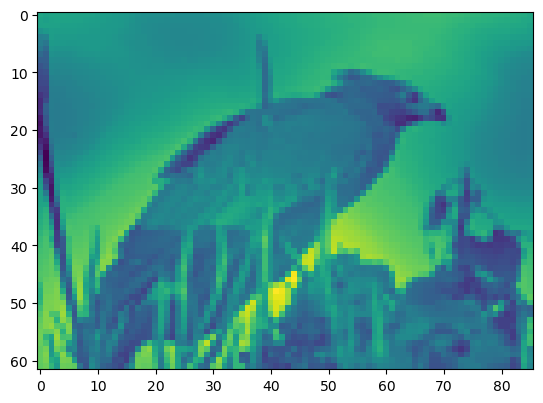

In [4]:
plt.imshow(dataset[120])

In [5]:
def create_dataloader(dataset, batch_size=256, reshuffle_after_epoch=True):
    '''
    Creates a DataLoader for Pytorch to train the autoencoder with the image data converted to a tensor.

    Args:
        dataset (4D numpy array): image dataset with shape (n_samples, n_channels, n_pixels_height, n_pixels_width).
        batch_size (int; default=32): the size of the batch updates for the autoencoder training.

    Returns:
        DataLoader (Pytorch DataLoader): dataloader that is ready to be used for training an autoencoder.
    '''
    if dataset.shape[-1] <= 3:
        dataset = np.transpose(dataset, (0,3,1,2))
    tensor_dataset = TensorDataset(torch.from_numpy(dataset).float(), torch.from_numpy(dataset).float())
    return DataLoader(tensor_dataset, batch_size=batch_size, shuffle=reshuffle_after_epoch)

In [6]:
train_loader = create_dataloader(dataset, batch_size=256, reshuffle_after_epoch=True)

## Model

In [7]:
class Conv_AE(nn.Module):
    def __init__(self, n_hidden=100):
        super().__init__()

        self.n_hidden = n_hidden
        #self.dim1, self.dim2 = 8, 33
        self.dim1, self.dim2 = 7, 10

        # Encoder
        self.conv1 = nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * self.dim1 * self.dim2, n_hidden)

        # Decoder
        self.fc2 = nn.Linear(n_hidden, 64 * self.dim1 * self.dim2)
        self.conv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=1)
        self.conv5 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, output_padding=1)
        self.conv6 = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1, output_padding=0)

    def encoder(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))  
        x = x.view(-1, 64 * self.dim1 * self.dim2)  
        x = F.relu(self.fc1(x))
        return x

    def decoder(self, x):
        # Decoder
        x = F.relu(self.fc2(x)) 
        x = x.view(-1, 64, self.dim1, self.dim2) 
        x = F.relu(self.conv4(x)) 
        x = F.relu(self.conv5(x))  
        x = torch.sigmoid(self.conv6(x))  
        return x

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h

    def backward(self, optimizer, criterion, x, y_true, alpha=0, beta=0):

        optimizer.zero_grad()

        y_pred, hidden = self.forward(x)
        recon_loss = criterion(y_pred, y_true)

        whitening_loss = 0
        sparsity_loss = 0
        batch_size, hidden_dim = hidden.shape
        if alpha != 0:
            C = torch.eye(hidden_dim, device='cuda') - torch.mm(hidden.t(), hidden)
            whitening_loss = alpha * torch.norm(C) / (batch_size*hidden_dim)
            
        if beta != 0:
            sparsity_loss = beta * torch.sum(torch.abs(hidden)) / (batch_size*hidden_dim)
        
        loss = recon_loss + whitening_loss + sparsity_loss
        loss.backward()

        optimizer.step()

        return recon_loss.item()

In [8]:
model = Conv_AE(n_hidden=1000)

## Training

In [9]:
def train_autoencoder(model, train_loader, num_epochs=1000, learning_rate=1e-5, alpha=0, beta=0):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
    criterion = nn.MSELoss()

    model = model.to('cuda')

    history = []
    for epoch in range(num_epochs):
        running_loss = 0.
        with tqdm(total=len(train_loader)) as pbar:
            for i, data in enumerate(train_loader, 0):
                inputs, _ = data
                inputs = inputs.to('cuda')

                loss = model.backward(optimizer=optimizer, criterion=criterion, x=inputs, y_true=inputs, alpha=alpha, beta=beta)
                running_loss += loss

                pbar.update(1)
                pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

        history.append(running_loss/len(train_loader))

    return history

In [10]:
history = train_autoencoder(model, train_loader, num_epochs=2000, learning_rate=1e-4, alpha=0, beta=0)

Epoch 128/2000, Loss: 0.0057: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 87.32it/s]


Epoch 256/2000, Loss: 0.0047: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 70.18it/s]


Epoch 384/2000, Loss: 0.0043: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 76.62it/s]


Epoch 512/2000, Loss: 0.0040: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 73.32it/s]


Epoch 640/2000, Loss: 0.0039: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 77.55it/s]


Epoch 768/2000, Loss: 0.0037: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 87.50it/s]


Epoch 896/2000, Loss: 0.0035: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 74.51it/s]


Epoch 1024/2000, Loss: 0.0034: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 75.72it/s]


Epoch 1152/2000, Loss: 0.0033: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 77.08it/s]


Epoch 1280/2000, Loss: 0.0032: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 70.15it/s]


Epoch 1408/2000, Loss: 0.0032: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 87.81it/s]


Epoch 1536/2000, Loss: 0.0031: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 87.05it/s]


Epoch 1664/2000, Loss: 0.0030: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 87.10it/s]


Epoch 1792/2000, Loss: 0.0029: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 86.54it/s]


Epoch 1920/2000, Loss: 0.0029: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 82.39it/s]


Epoch 2000/2000, Loss: 0.0028: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 79.68it/s]


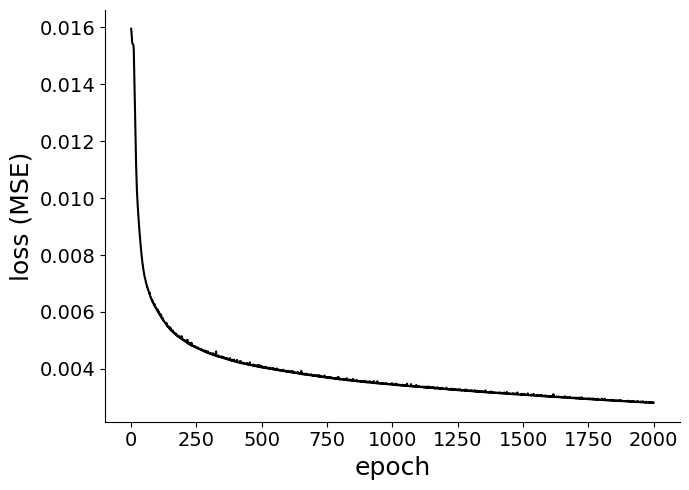

In [18]:
plt.figure(figsize=(7,5))

plt.plot(history, color='black')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss (MSE)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sb.despine()
plt.tight_layout()

#plt.savefig('plots/loss.png', dpi=600)
plt.show()

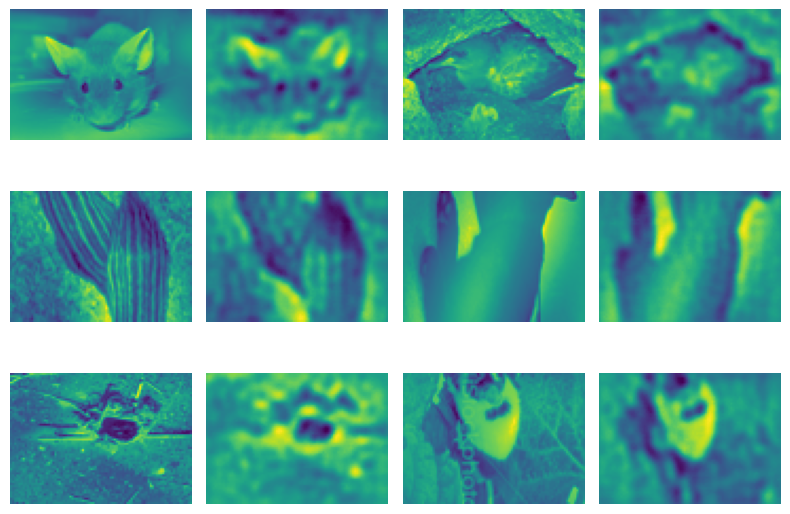

In [19]:
plt.figure(figsize=(8,6))

indxs = np.random.randint(0, 1000, 6)

for i in range(12):
    plt.subplot(3,4,i+1)
    if i%2==0:
        plt.imshow(dataset[indxs[int(i/2)]])
    else:
        plt.imshow(predict(dataset[indxs[int(i/2)]], model))
    plt.axis('off')

plt.tight_layout()
#plt.savefig('plots/reconstructed_imgs.png', dpi=600)
plt.show()

## Power-law and pairwise correlations

In [13]:
embeddings = get_latent_vectors(dataset, model)

In [14]:
embeddings_reduced = PCA().fit(embeddings)
variances = embeddings_reduced.explained_variance_ratio_

In [15]:
start_fit = 10
cutoff_fit = 50
x = np.arange(1, len(variances)+1)
y = variances
m, b = np.polyfit(np.log(x[start_fit:cutoff_fit]), np.log(y[start_fit:cutoff_fit]), 1)

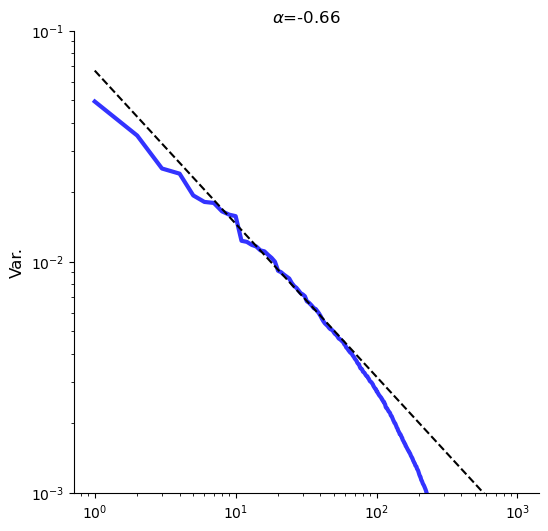

In [16]:
plt.figure(figsize=(6,6))

plt.plot(x, y, color='blue', linewidth=3, alpha=0.8)

x_fit = x
y_fit = np.exp(b) * x_fit**m
plt.plot(x_fit, y_fit, linestyle='--', color='black', linewidth=1.5)

plt.title('$\u03B1$='+str(np.around(m, 2)), fontsize=12)

if i >= (10-1)*11-2:
    plt.xlabel('PC dim.', fontsize=12)
if i%11==0: 
    plt.ylabel('Var.', fontsize=12)
plt.xscale('log')
plt.yscale('log')

#plt.xlim(0,350)
plt.ylim(1e-3,1e-1)

sb.despine()

#plt.savefig('plots/calciumData_powerLawFits.png', dpi=600)

plt.show()

In [17]:
from scipy.stats import pearsonr

def compute_pairwise_correlations(data):
    """
    Compute the overall pairwise correlation level for each session of each animal.

    Parameters:
    data (dict): A nested dictionary where the first key is the animal ID and the second key is the session ID, 
                 mapping to a data matrix for that session.
    p_value_threshold (float): The threshold for considering correlations as significant.

    Returns:
    correlations (dict): A nested dictionary with the mean correlation for each session of each animal.
    """
    n_neurons = data.shape[1]
    correlations = []
    for i in range(n_neurons):
        for j in range(i+1, n_neurons):
            corr, p_value = pearsonr(data[:, i], data[:, j])
            correlations.append(corr)

    return correlations

In [47]:
correlations = compute_pairwise_correlations(embeddings)

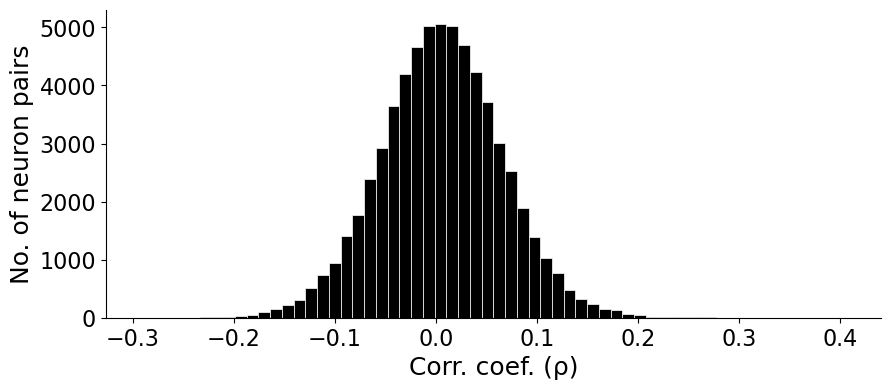

In [48]:
plt.figure(figsize=(10,4))

plt.hist(correlations, bins=60, color='k', alpha=1, edgecolor='white', linewidth=.5)

#plt.axvline(x=np.nanmean(correlations_nonortho), color='k', linestyle='--')

plt.xlabel('Corr. coef. (ρ)', fontsize=18)
plt.ylabel('No. of neuron pairs', fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.xlim(-0.05, 0.1)

sb.despine()
#plt.savefig('plots/pairwiseCorrDistr.png', dpi=600)
plt.show()